In [35]:
# !pip install numpy
# !pip install scipy
# !pip install random
# !pip install pandas
# !pip install math
# !pip install os
# !pip install scikit-learn
# !pip install torch
# !pip install scikit-image

In [36]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch, math
import torch.nn as nn
import torch.nn.functional as F
from functools import reduce
import os
from PIL import Image
import numpy as np
import random
from skimage import io, measure


import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Reshape, LeakyReLU
os.environ["SM_FRAMEWORK"] = "tf.keras"
import torch
import torch.nn as nn

Setting the seed of GPU

In [37]:
# def seed_torch(seed = 123):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True

# seed_torch()

# 2. SAFNet Benchmark

In [38]:
class FeatNet(nn.Module):
    def __init__(self):
        super(FeatNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.bn1_1 = nn.BatchNorm2d(16)

        self.conv1_1 = nn.Conv2d(16, 16, 3, 1, 1)
        self.bn1_1 = nn.BatchNorm2d(16)
        self.conv1_2 = nn.Conv2d(16, 16, 3, 1, 1)
        self.bn1_2 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 1 ,2, 1)

        self.conv2_1 = nn.Conv2d(32, 32, 3, 1, 1)
        self.bn2_1 = nn.BatchNorm2d(32)
        self.conv2_2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.bn2_2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 1, 2, 1)

        self.conv3_1 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn3_1 = nn.BatchNorm2d(64)
        self.conv3_2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn3_2 = nn.BatchNorm2d(64)

        # Feature fusion
        self.conv_fusion1 = nn.Conv2d(16, 64, 1, 4, 2)
        self.conv_fusion2 = nn.Conv2d(32, 64, 1, 2, 1)

    def forward(self, x):

        x1 = self.conv1(x)
        x = F.relu(self.bn1_1(self.conv1_1(x1)))
        x_1 = F.relu(self.bn1_2(self.conv1_2(x)))
        x = x1 + x_1
        x2 = self.conv2(x)
        x = F.relu(self.bn2_1(self.conv2_1(x2)))
        x_2 = F.relu(self.bn2_2(self.conv2_2(x)))
        x = x2 + x_2
        x3 = self.conv3(x)
        x = F.relu(self.bn3_1(self.conv3_1(x3)))
        x_3 = F.relu(self.bn3_2(self.conv3_2(x)))
        return x_1, x_2, x_3

class FeatFuse(nn.Module):
    def __init__(self):
        super(FeatFuse, self).__init__()

        self.conv_fusion1 = nn.Conv2d(16, 64, 1, 4, 3)
        self.conv_fusion2 = nn.Conv2d(32, 64, 1, 2, 1)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(64, 8)
        self.fc2 = nn.Linear(8, 64*3)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x1, x2, x3):

        batch_size = x1.size(0)
        out_channels = x3.size(1)
        x1 = self.conv_fusion1(x1)
        x2 = self.conv_fusion2(x2)
        output = []
        output.append(x1)
        output.append(x2)
        output.append(x3)
        x = x1 + x2 + x3

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        a_b = x.reshape(batch_size, 3, out_channels, -1)
        a_b = self.softmax(a_b)
        #the part of selection
        a_b = list(a_b.chunk(3, dim=1))#split to a and b
        a_b = list(map(lambda x:x.reshape(batch_size, out_channels, 1, 1), a_b))
        V = list(map(lambda x,y:x*y, output, a_b))
        V = reduce(lambda x,y:x+y, V)
        return V

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.featnet = FeatNet()
        self.featfuse = FeatFuse()
        self.featnet1 = FeatNet()
        self.featfuse1 = FeatFuse()
        #self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 2)

        self.global_pool1 = nn.AdaptiveAvgPool2d(1)
        self.global_pool2 = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(64, 2)
        self.fc2 = nn.Linear(64, 2)


    def forward(self, x, y):

        x1_1, x1_2, x1_3 = self.featnet(x)
        x2_1, x2_2, x2_3 = self.featnet1(y)

        feat_11 = self.featfuse(x1_1, x1_2, x1_3)
        feat_22 = self.featfuse1(x2_1, x2_2, x2_3)
        feat_1 = self.global_pool1(feat_11)
        feat_2 = self.global_pool2(feat_22)
        feat_1 = feat_1.view(feat_1.size(0), -1)
        feat_2 = feat_2.view(feat_2.size(0), -1)
        feat_1 = self.fc1(feat_1)
        feat_2 = self.fc2(feat_2)

        feature_corr = self.xcorr_depthwise(feat_11, feat_22)
        feat = feature_corr.view(feature_corr.size(0), -1)
        #feat = global_pool(feature_corr)
        feat = self.fc(feat)
        # print(feat_1.shape, feat_2.shape, feat.shape)
        return feat_1, feat_2, feat

    def xcorr_depthwise(self, x, kernel):

        batch = kernel.size(0)
        channel = kernel.size(1)
        x = x.view(1, batch*channel, x.size(2), x.size(3))
        kernel = kernel.view(batch*channel, 1, kernel.size(2), kernel.size(3))
        out = F.conv2d(x, kernel, groups=batch*channel)
        out = out.view(batch, channel, out.size(2), out.size(3))
        return out

In [39]:
# from google.colab import drive
# drive.mount('/content/drive')

# SCNN Model

In [40]:
class SCNNModel(nn.Module):
    def __init__(self, image_height, image_width, image_channel):
        super(SCNNModel, self).__init__()

        self.activation_fn = nn.LeakyReLU(0.2)
        
        # Convolutional block
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )

        # Separate paths for SAR image 1
        self.sar_output1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),   
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),    
            self.activation_fn,
            nn.Flatten()
        )

        # Separate paths for SAR image 2
        self.sar_output2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),   
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),    
            self.activation_fn,
            nn.Flatten()
        )

        # Pairwise skipped connection
        self.sar_output1_skip = nn.Linear(128, 256)
        self.sar_output2_skip = nn.Linear(128, 256)

        # Fully connected layers for prediction
        self.fc_prediction = nn.Sequential(
            nn.Linear(32 * 4 * 2, 512),  # Adjusted input size
            self.activation_fn,
            nn.Linear(512, 256),           # Adjusted output channels
            self.activation_fn,
            nn.Linear(256, 2)              # Output size is (batch_size, 2)
        )

    def forward(self, sar_input1, sar_input2):
        # Convolutional block
        sar_output1 = self.conv_block(sar_input1)
        sar_output2 = self.conv_block(sar_input2)

        # Separate paths for SAR image 1
        sar_output1 = self.sar_output1(sar_output1)

        # Separate paths for SAR image 2
        sar_output2 = self.sar_output2(sar_output2)

        # Pairwise skipped connection
        sar_output1_skip = self.sar_output1_skip(sar_output1)
        merged_output = torch.cat((sar_output2, sar_output1_skip), dim=1)

        # Pairwise skipped connection
        sar_output2_skip = self.sar_output2_skip(sar_output2)
        merged_output = torch.cat((merged_output, sar_output2_skip), dim=1)

        # Fully connected layers for prediction
        merged_output = torch.cat((sar_output1, sar_output2), dim=1)
        predictions = self.fc_prediction(merged_output)

        return sar_output1, sar_output2, predictions

# SCNN with Attention Network

In [41]:
class SCNNAttentionModel(nn.Module):
    def __init__(self, image_height, image_width, image_channel):
        super(SCNNAttentionModel, self).__init__()

        # Spatial Attention Mechanism
        self.attention_weights = nn.Conv2d(512, 1, kernel_size=1)  # Adjust channels to match the concatenated feature maps
        

        self.activation_fn = nn.LeakyReLU(0.2)
        
        # Convolutional block
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )

        # Separate paths for SAR image 1
        self.sar_output1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),   
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),    
            self.activation_fn,
            nn.Flatten()
        )

        # Separate paths for SAR image 2
        self.sar_output2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),   
            self.activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),    
            self.activation_fn,
            nn.Flatten()
        )

        # Pairwise skipped connection
        self.sar_output1_skip = nn.Linear(128, 256)
        self.sar_output2_skip = nn.Linear(128, 256)

        # Fully connected layers for prediction
        self.fc_prediction = nn.Sequential(
            nn.Linear(32 * 4 * 2, 512),  # Adjusted input size
            self.activation_fn,
            nn.Linear(512, 256),           # Adjusted output channels
            self.activation_fn,
            nn.Linear(256, 2)              # Output size is (batch_size, 2)
        )

        self.output_reshape = lambda x: x.view(-1, image_height, image_width)

    def forward(self, sar_input1, sar_input2):
        # Convolutional block
        sar_output1 = self.conv_block(sar_input1)
        sar_output2 = self.conv_block(sar_input2)

        # Spatial Attention Mechanism
        attention_weights = self.attention_weights(torch.cat((sar_output1, sar_output2), dim=1))
        sar_output1_attended = sar_output1 * attention_weights
        sar_output2_attended = sar_output2 * attention_weights

        # Separate paths for SAR image 1
        sar_output1 = self.sar_output1(sar_output1_attended)

        # Separate paths for SAR image 2
        sar_output2 = self.sar_output2(sar_output2_attended)
        
        # Pairwise skipped connection
        sar_output1_skip = self.sar_output1_skip(sar_output1)
        merged_output = torch.cat((sar_output2, sar_output1_skip), dim=1)

        # Pairwise skipped connection
        sar_output2_skip = self.sar_output2_skip(sar_output2)
        merged_output = torch.cat((merged_output, sar_output2_skip), dim=1)

        # Fully connected layers for prediction
        merged_output = torch.cat((sar_output1, sar_output2), dim=1)
        predictions = self.fc_prediction(merged_output)

        return sar_output1, sar_output2, predictions

# 3. Data processing function

## keep gt > for Yellow River and gt >= 0 for Ottawa Dataset

In [42]:
def createPosWithoutZero(hsi, gt):
    print("uniques ",np.unique(gt))
    mask = gt > 0
    return [(i,j) for i , row  in enumerate(mask) for j , row_element in enumerate(row) if row_element]

In [43]:
def addZeroPadding(X, margin=2):
    newX = np.zeros((
        X.shape[0] + 2 * margin,
        X.shape[1] + 2 * margin,
        X.shape[2]
              ))
    newX[margin:X.shape[0]+margin, margin:X.shape[1]+margin, :] = X
    return newX

def createImgCube(X ,gt ,pos:list ,windowSize=25):
    margin = (windowSize-1)//2
    zeroPaddingX = addZeroPadding(X, margin=margin)
    dataPatches = np.zeros((pos.__len__(), windowSize, windowSize, X.shape[2]))
    if( pos[-1][1]+1 != X.shape[1] ):
        nextPos = (pos[-1][0] ,pos[-1][1]+1)
    elif( pos[-1][0]+1 != X.shape[0] ):
        nextPos = (pos[-1][0]+1 ,0)
    else:
        nextPos = (0,0)
    return np.array([zeroPaddingX[i:i+windowSize, j:j+windowSize, :] for i,j in pos ]),\
    np.array([gt[i,j] for i,j in pos]) ,\
    nextPos

def createPos(shape:tuple, pos:tuple, num:int):
    if (pos[0]+1)*(pos[1]+1)+num >shape[0]*shape[1]:
        num = shape[0]*shape[1]-( (pos[0])*shape[1] + pos[1] )
    return [(pos[0]+(pos[1]+i)//shape[1] , (pos[1]+i)%shape[1] ) for i in range(num) ]



def splitTrainTestSet(X, gt, testRatio, randomState=111):

    X_train, X_test, gt_train, gt_test = train_test_split(X, gt, test_size=testRatio, random_state=randomState, stratify=gt)
    return X_train, X_test, gt_train, gt_test

def createImgPatch(lidar, pos:list, windowSize=25):

    margin = (windowSize-1)//2
    zeroPaddingLidar = np.zeros((
      lidar.shape[0] + 2 * margin,
      lidar.shape[1] + 2 * margin
            ))
    zeroPaddingLidar[margin:lidar.shape[0]+margin, margin:lidar.shape[1]+margin] = lidar
    return np.array([zeroPaddingLidar[i:i+windowSize, j:j+windowSize] for i,j in pos ])

def minmax_normalize(array):
    amin = np.min(array)
    amax = np.max(array)
    return (array - amin) / (amax - amin)
def postprocess(res):
    res_new = res
    res = measure.label(res, connectivity=2)
    num = res.max()
    for i in range(1, num+1):
        idy, idx = np.where(res==i)
        if len(idy) <= 20:
            res_new[idy, idx] = 0
    return res_new

## Input the Yellow River Dataset

In [44]:
data_path = './'
data_traingt = sio.loadmat(os.path.join('mask_train.mat'))['mask_train']
data_testgt = sio.loadmat(os.path.join( 'mask_test.mat'))['mask_test']
im1 = sio.loadmat(os.path.join('data_1.mat'))['data']
im2 = sio.loadmat(os.path.join('data_2.mat'))['data']

im1 = im1.reshape(im1.shape[0], im1.shape[1], 1)
im2 = im2.reshape(im2.shape[0], im2.shape[1], 1)

height , width, c = im1.shape

## Input the Ottawa Dataset

In [45]:
# image_path_gt = "ottawa_gt.bmp"
# im_gt = Image.open(image_path_gt)
# im_gt = im_gt.convert('L')
# im_gt = np.array(im_gt)
# im_gt[im_gt == 255] = 1

# data_traingt = im_gt
# data_testgt = im_gt

# image_path1 = "ottawa_1.bmp"
# im1 = Image.open(image_path1)
# im1_gray = im1.convert('L')
# im1_array = np.array(im1_gray)
# im1_array[im1_array == 255] = 1
# # Reshape the NumPy array to add an extra dimension
# im1 = im1_array.reshape(im1_array.shape[0], im1_array.shape[1], 1)

# # print(im1.shape)

# image_path2 = "ottawa_2.bmp"
# im2 = Image.open(image_path2)
# im2_gray = im2.convert('L')
# im2_array = np.array(im2_gray)
# im2_array[im2_array == 255] = 1
# # Reshape the NumPy array to add an extra dimension
# im2 = im2_array.reshape(im2_array.shape[0], im2_array.shape[1], 1)


# data_traingt = np.array(im_gt)
# data_testgt = np.array(im_gt)

In [46]:
windowSize = 7 # patch size
class_num = 2
testRatio = 0.2 # the ratio of Validation set
trainRatio = 0.9 # the ratio of Training set selected from preclassification


# All pseudo-label set
train_1, labels ,_ = createImgCube(im1, data_traingt, createPosWithoutZero(im1, data_traingt), windowSize=windowSize)
train_2, _ ,_ = createImgCube(im2, data_traingt, createPosWithoutZero(im2, data_traingt), windowSize=windowSize)

# training set selected from pseudo-label set
train_1, _, train_labels, _ = splitTrainTestSet(train_1, labels, trainRatio, randomState=111)
train_2, _, _, _ = splitTrainTestSet(train_2, labels, trainRatio, randomState=111)

# data augmentation if need
Xh = []
Xl = []
y = []
for i in range(train_1.shape[0]):
    Xh.append(train_1[i])
    Xl.append(train_2[i])

    noise = np.random.normal(0.0, 0.01, size=train_1[0].shape)
    noise2 = np.random.normal(0.0, 0.01, size=train_2[0].shape)
    Xh.append(np.flip(train_1[i] + noise, axis=1))
    Xl.append(np.flip(train_2[i] + noise2, axis=1))

    k = np.random.randint(4)
    Xh.append(np.rot90(train_1[i], k=k))
    Xl.append(np.rot90(train_2[i], k=k))

    y.append(train_labels[i])
    y.append(train_labels[i])
    y.append(train_labels[i])

labels = np.asarray(y, dtype=np.int8)
train_1 = np.asarray(Xh, dtype=np.float32)
train_2 = np.asarray(Xl,dtype=np.float32)
train_1 = torch.from_numpy(train_1.transpose(0,3,1,2)).float()
train_2 = torch.from_numpy(train_2.transpose(0,3,1,2)).float()

# Select a partial validation set from the training set
X_train, X_val, train_labels, val_labels = splitTrainTestSet(train_1, labels, testRatio, randomState=111)
X_train_2, X_val_2, _, _ = splitTrainTestSet(train_2, labels, testRatio, randomState=111)

# testing set
X_test, test_labels ,_ = createImgCube(im1, data_traingt, createPosWithoutZero(im1, data_testgt), windowSize=windowSize)
X_test_2, _ ,_ = createImgCube(im2, data_traingt, createPosWithoutZero(im2, data_testgt), windowSize=windowSize)
X_test = torch.from_numpy(X_test.transpose(0,3,1,2)).float()
X_test_2 = torch.from_numpy(X_test_2.transpose(0,3,1,2)).float()

print (X_train.shape)
print (X_val.shape)
print (X_test.shape)
print("Creating dataloader")
print(np.unique(train_labels))

uniques  [0 1 2]
uniques  [0 1 2]
uniques  [1 2]
uniques  [1 2]
torch.Size([20220, 1, 7, 7])
torch.Size([5055, 1, 7, 7])
torch.Size([89046, 1, 7, 7])
Creating dataloader
[1 2]


## For Ottawa Dataset

In [47]:
# """ Training dataset"""
# class TrainDS(torch.utils.data.Dataset):
#     def __init__(self):
#         self.len = train_labels.shape[0]
#         self.hsi = torch.FloatTensor(X_train)
#         self.lidar = torch.FloatTensor(X_train_2)
#         self.labels = torch.LongTensor(train_labels)
#     def __getitem__(self, index):
#         return self.hsi[index], self.lidar[index], self.labels[index]
#     def __len__(self):
#         return self.len

# """ Testing dataset"""
# class TestDS(torch.utils.data.Dataset):
#     def __init__(self):
#         self.len = test_labels.shape[0]
#         self.hsi = torch.FloatTensor(X_test)
#         self.lidar = torch.FloatTensor(X_test_2)
#         self.labels = torch.LongTensor(test_labels)
#     def __getitem__(self, index):
#         return self.hsi[index], self.lidar[index], self.labels[index]
#     def __len__(self):
#         return self.len
# """ Validation dataset"""
# class ValDS(torch.utils.data.Dataset):
#     def __init__(self):
#         self.len = val_labels.shape[0]
#         self.hsi = torch.FloatTensor(X_val)
#         self.lidar = torch.FloatTensor(X_val_2)
#         self.labels = torch.LongTensor(val_labels )
#     def __getitem__(self, index):
#         return self.hsi[index], self.lidar[index], self.labels[index]
#     def __len__(self):
#         return self.len


# # generate trainloader and valloader
# trainset = TrainDS()
# testset  = TestDS()
# valset = ValDS()
# train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = 64, shuffle = True, num_workers = 0, drop_last = True)
# test_loader = torch.utils.data.DataLoader(dataset = testset, batch_size = 64, shuffle = False, num_workers = 0, drop_last = True)
# val_loader = torch.utils.data.DataLoader(dataset = valset, batch_size = 64, shuffle = False, num_workers = 0, drop_last = True)

## For Yellow River Dataset

In [48]:
""" Training dataset"""
class TrainDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = train_labels.shape[0]
        self.hsi = torch.FloatTensor(X_train)
        self.lidar = torch.FloatTensor(X_train_2)
        self.labels = torch.LongTensor(train_labels - 1)
    def __getitem__(self, index):
        return self.hsi[index], self.lidar[index], self.labels[index]
    def __len__(self):
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = test_labels.shape[0]
        self.hsi = torch.FloatTensor(X_test)
        self.lidar = torch.FloatTensor(X_test_2)
        self.labels = torch.LongTensor(test_labels - 1)
    def __getitem__(self, index):
        return self.hsi[index], self.lidar[index], self.labels[index]
    def __len__(self):
        return self.len
""" Validation dataset"""
class ValDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = val_labels.shape[0]
        self.hsi = torch.FloatTensor(X_val)
        self.lidar = torch.FloatTensor(X_val_2)
        self.labels = torch.LongTensor(val_labels - 1)
    def __getitem__(self, index):
        return self.hsi[index], self.lidar[index], self.labels[index]
    def __len__(self):
        return self.len

In [49]:
# generate trainloader and valloader
trainset = TrainDS()
testset  = TestDS()
valset = ValDS()
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = 64, shuffle = True, num_workers = 0, drop_last = True)
test_loader = torch.utils.data.DataLoader(dataset = testset, batch_size = 64, shuffle = False, num_workers = 0, drop_last = True)
val_loader = torch.utils.data.DataLoader(dataset = valset, batch_size = 64, shuffle = False, num_workers = 0, drop_last = True)

In [50]:
changed_pixels_positions = createPosWithoutZero(im1, data_testgt)

uniques  [1 2]


# 6. Running

In [51]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2)+(1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

def calc_loss(x1, x2, outputs, labels, alpha):

    criterion = nn.CrossEntropyLoss()
    loss1 = criterion(outputs, labels)

    contrastive = ContrastiveLoss()
    loss2 = contrastive(x1, x2, labels)

    loss_sum = loss1 + alpha* loss2
    return loss_sum

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for i, (inputs_1, inputs_2, labels) in enumerate(train_loader):

        inputs_1, inputs_2 = inputs_1.to(device), inputs_2.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        feat_1, feat_2, outputs = model(inputs_1, inputs_2)
        loss = calc_loss(feat_1, feat_2, outputs, labels, alpha = 1)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))

import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score

def test(model, device, test_loader):
    model.eval()
    predicted_changes = []
    test_labels_list = []
    for inputs_1, inputs_2, labels in test_loader:
        inputs_1, inputs_2 = inputs_1.to(device), inputs_2.to(device)
        _, _, outputs = model(inputs_1, inputs_2)
        
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        predicted_changes.extend(outputs)
        test_labels_list.extend(labels.numpy())

    predicted_changes = np.array(predicted_changes)
    test_labels = np.array(test_labels_list)

    # Calculate metrics
    FP = np.sum((predicted_changes == 1) & (test_labels == 0))
    FN = np.sum((predicted_changes == 0) & (test_labels == 1))
    OE = (FP + FN) / len(test_labels) * 100
    PCC = 100 - OE
    TP = np.sum((predicted_changes == 1) & (test_labels == 1))
    TN = np.sum((predicted_changes == 0) & (test_labels == 0))

    total = len(test_labels)
    positive_actual = np.sum(test_labels == 1)
    positive_predicted = np.sum(predicted_changes == 1)
    negative_actual = total - positive_actual
    negative_predicted = total - positive_predicted
    Pe = ((positive_actual / total) * (positive_predicted / total)) + ((negative_actual / total) * (negative_predicted / total))
    P0 = (TP + TN) / total
    P_e = (positive_actual / total) ** 2 + (negative_actual / total) ** 2
    kappa = (P0 - Pe) / (1 - Pe)

    # Class-wise precision, recall, and F1 score
    precision_0 = precision_score(test_labels, predicted_changes, labels=[0], average=None)[0]
    recall_0 = recall_score(test_labels, predicted_changes, labels=[0], average=None)[0]
    f1_0 = f1_score(test_labels, predicted_changes, labels=[0], average=None)[0]

    precision_1 = precision_score(test_labels, predicted_changes, labels=[1], average=None)[0]
    recall_1 = recall_score(test_labels, predicted_changes, labels=[1], average=None)[0]
    f1_1 = f1_score(test_labels, predicted_changes, labels=[1], average=None)[0]

    # Calculate accuracy
    accuracy = (TP + TN) / len(test_labels) * 100

    return FP, FN, OE, PCC, TP, TN, precision_0, recall_0, f1_0, precision_1, recall_1, f1_1, accuracy, predicted_changes ,kappa

def test2(model, device, test_loader):
    model.eval()
    count = 0
    for inputs_1, inputs_2, labels in test_loader:

        inputs_1, inputs_2 = inputs_1.to(device), inputs_2.to(device)
        _, _, outputs = model(inputs_1, inputs_2)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)

        if count == 0:
            y_pred_test =  outputs
            test_labels = labels
            count = 1
        else:
            y_pred_test = np.concatenate( (y_pred_test, outputs) )
            test_labels = np.concatenate( (test_labels, labels) )
    a = 0
    for c in range(len(y_pred_test)):
        if test_labels[c]==y_pred_test[c]:
            a = a+1
    acc = a/len(y_pred_test)*100
    print('%.2f' %(a/len(y_pred_test)*100))

    return acc

## Hyperparameters

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, else use CPU
num_epochs = 50
lr = 0.001
momentum = 0.9
betas = (0.9, 0.999)

image_height = image_width = 64
image_channel = 1

## Initialise the model

In [59]:
# model = Net().to(device)
# model = SCNNModel(image_height, image_width, image_channel)
model = SCNNAttentionModel(image_height, image_width, image_channel)

In [60]:
# Move the model to the appropriate device (GPU or CPU)
model.eval().to(device)
params_to_update = list(model.parameters())

optimizer = torch.optim.Adam(params_to_update, lr=lr, betas=betas)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum,weight_decay=0.0005)

best_acc = 0

for epoch in range(num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    # validation accuracy
    acc = test2(model, device, val_loader)
    if acc >= best_acc:
        best_acc = acc
        print("Save model!")
        torch.save(model.state_dict(),'model/model.pth')

[Epoch: 1]   [loss avg: 4296.1196]   [current loss: 0.7296]
97.68
Save model!
[Epoch: 2]   [loss avg: 13.5654]   [current loss: 0.0088]
99.64
Save model!
[Epoch: 3]   [loss avg: 3.9636]   [current loss: 0.0052]
99.56
[Epoch: 4]   [loss avg: 3.2497]   [current loss: 0.4948]
98.42
[Epoch: 5]   [loss avg: 2.1419]   [current loss: 0.0128]
98.86
[Epoch: 6]   [loss avg: 1.1131]   [current loss: 0.0051]
99.84
Save model!
[Epoch: 7]   [loss avg: 0.9199]   [current loss: 0.0062]
99.88
Save model!
[Epoch: 8]   [loss avg: 0.5116]   [current loss: 0.0098]
99.50
[Epoch: 9]   [loss avg: 0.4488]   [current loss: 0.0117]
99.90
Save model!
[Epoch: 10]   [loss avg: 0.9165]   [current loss: 0.0026]
99.84
[Epoch: 11]   [loss avg: 0.4055]   [current loss: 0.0020]
99.86
[Epoch: 12]   [loss avg: 1.5031]   [current loss: 0.0938]
99.72
[Epoch: 13]   [loss avg: 3.3427]   [current loss: 0.0440]
99.84
[Epoch: 14]   [loss avg: 0.6262]   [current loss: 0.0023]
99.90
Save model!
[Epoch: 15]   [loss avg: 0.4347]   [c

# 7. Record the final change map

Accuracy: 94.39252336448598
False Positives: 30
False Negatives: 172
Overall Error (%): 0.22690510424155283
Positive Correct Classification (%): 99.77309489575845
Class 0 Precision: 0.9519080286645565
Class 0 Recall: 0.9996292909571708
Class 0 F1 Score: 0.9751851918822969
Class 1 Precision: 0.7760455332838406
Class 1 Recall: 0.9480048367593712
Class 1 F1 Score: 0.8534494489046129
Kappa: 0.2917827783593786


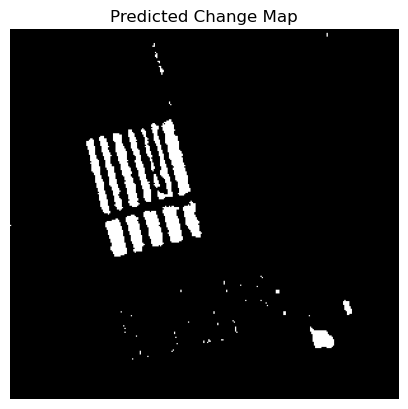

In [61]:
model.load_state_dict(torch.load('model/model.pth'))
FP, FN, OE, PCC, TP, TN, precision_0, recall_0, f1_0, precision_1, recall_1, f1_1, accuracy, predicted_changes, kappa = test(model, device, test_loader)
print(f"Accuracy: {accuracy}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"Overall Error (%): {OE}")
print(f"Positive Correct Classification (%): {PCC}")
print(f"Class 0 Precision: {precision_0}")
print(f"Class 0 Recall: {recall_0}")
print(f"Class 0 F1 Score: {f1_0}")
print(f"Class 1 Precision: {precision_1}")
print(f"Class 1 Recall: {recall_1}")
print(f"Class 1 F1 Score: {f1_1}")
print(f"Kappa: {kappa}")

binary_image = np.full_like(im1, 0, dtype=np.uint8)

# Map predicted changes to the corresponding indices in changed_pixels_positions
for idx, value in enumerate(predicted_changes):
    # print(idx, value)
    if value == 0:
        y, x = changed_pixels_positions[idx]
        binary_image[y, x] = 0  # Set as black for unchanged pixels
    else:
        y, x = changed_pixels_positions[idx]
        binary_image[y, x] = 255  # Set as white for changed pixels

import matplotlib.pyplot as plt
# Visualize the binary image
plt.imshow(binary_image[:, :, 0], cmap='gray')
plt.axis('off')
plt.title('Predicted Change Map')
# plt.savefig("SCNN_Attention_YELLOW_RIVER.png")
plt.show()
